## Isothermal alloy solidification - (Fe-Cr)

Here, we simulate Fe-Cr alloy solidification using phase field method. We use the grand potential formulation to solve for the composition fields. Free energies taken from Fe-Cr_PhaseDiag.ipynb (parabolic approximations)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Free energy densities are of the form

$$f_{s/l} = a(T) x^2 + b(T) x + c(T) J/cm^3$$

Where $x = X_{Cr}$. Look to Parabolic_appx_2.ipynb for more details

In [2]:
def a_bcc(T):
    
    a0  = 1.48573160876362e+17
    a1  = -533959921453932
    a2  = 822132803086.902
    a3  = -702980512.848244
    a4  = 360524.747722819
    a5  = -110.896060621478
    a6  = 0.0189435512365575
    a7  = -1.38632597908866e-06
    
    return a0+a1*T+a2*T**2+a3*T**3+a4*T**4+a5*T**5+a6*T**6+a7*T**7


def b_bcc(T):
    
    a0  = -5.74988758596428e+16
    a1  = 205888139888278
    a2  = -315807244126.921
    a3  = 268986846.012062
    a4  = -137396.890145104
    a5  = 42.0876190128756
    a6  = -0.00715869712372715
    a7  = 5.21561342179072e-07
    
    return a0+a1*T+a2*T**2+a3*T**3+a4*T**4+a5*T**5+a6*T**6+a7*T**7

def c_bcc(T):
    
    a0  = 2.24280665461153e+15
    a1  = -7672646510499.51
    a2  = 11198716987.0004
    a3  = -9033989.94168094
    a4  = 4346.56671776632
    a5  = -1.24600097323119
    a6  = 0.000196784418722745
    a7  = -1.31853064948386e-08
    
    return a0+a1*T+a2*T**2+a3*T**3+a4*T**4+a5*T**5+a6*T**6+a7*T**7


def a_liq(T):
    
    a0  = 1.34402214639946e+17
    a1  = -483041743694295
    a2  = 743752241655.028
    a3  = -635975330.764811
    a4  = 326169.32777634
    a5  = -100.331108793173
    a6  = 0.0171392878798394
    a7  = -1.25432210980197e-06
    
    return a0+a1*T+a2*T**2+a3*T**3+a4*T**4+a5*T**5+a6*T**6+a7*T**7

def b_liq(T):
    
    a0  = -5.02636054089711e+16
    a1  = 180002914938405
    a2  = -276136627305.307
    a3  = 235226732.682717
    a4  = -120167.335429361
    a5  = 36.8144381507289
    a6  = -0.00626257159618173
    a7  = 4.56330855404118e-07
    
    return a0+a1*T+a2*T**2+a3*T**3+a4*T**4+a5*T**5+a6*T**6+a7*T**7

def c_liq(T):
    
    a0  = 2.12467464521575e+15
    a1  = -7310151586822.15
    a2  = 10738897653.4874
    a3  = -8727402.7907034
    a4  = 4235.13227776304
    a5  = -1.22627109914018
    a6  = 0.00019598329226659
    a7  = -1.33213290371344e-08

    return a0+a1*T+a2*T**2+a3*T**3+a4*T**4+a5*T**5+a6*T**6+a7*T**7


In [27]:
# Scaling Factors

# Energy

R = 8.314   #J/mol/K
T = 1810    #K
V_m = 7.09e-6 #m^3/mol

f_scale = R*T/V_m
print("Energy scale = ")
print(f_scale)

# Length
sigma = 3.2 #J/m^2

l_scale = sigma/f_scale
print("\nLength scale = ")
print(l_scale)


# Time
D_l = 3.2e-9 #m^2/s

t_scale = l_scale**2/D_l
print("\nTime scale = ")
print(t_scale)

Energy scale = 
2122473906.9111426

Length scale = 
1.507674600653627e-09

Time scale = 
7.10338344205023e-10


In [28]:
# Constants

W = 1
interface_width = 1e-5    #m
ep = interface_width/2.5
dx = interface_width/10

dt = 1e-6 #s

In [29]:
# Calculate Relaxation coefficient

M = 0.063828
F = 0.158741

c_liq_mueq = 3.06752518e-01
c_sol_mueq = 3.34696064e-01

print(D_l/a_liq(T))
tau = ep*(c_liq_mueq - c_sol_mueq)**2/(D_l/a_liq(T))*(M+F)
print(tau)

5.941320582910805e-19
1170050785.4167821


In [5]:
# Now, for the approximate free energies
# Units: J/m^3

def f_s(x,T):
    
    a = a_bcc(T)
    b = b_bcc(T)
    c = c_bcc(T)
    
    return a*x**2 + b*x + c

def f_l(x,T):
    
    a = a_liq(T)
    b = b_liq(T)
    c = c_liq(T)
    
    return a*x**2 + b*x + c

print(f_s(0.3,1800))
print(f_l(0.3,1800))

-15642127716.58
-15637604483.325


The chemical potential($\mu = \mu_{Cr} - \mu_{Fe}$) is chosen as the independent variable (as opposed to the concentration) So, the natural choice of functional to descrube the system is the Grand Potential funcational: 

$$\Omega[\phi,T] = \int_V \Psi(T,\mu,\phi) + \bigg( \epsilon a(\nabla \phi)+ \frac{1}{\epsilon} w(\phi) \bigg) dV$$

Here, $\Psi$ is the grand potential density function given by (for one phase)

$$\Psi^{(s/l)}(\mu,T) = \frac{1}{V_m} \big[ F_m^{s/l}(\mu,T) - \mu c^{s/l}(\mu,T) \big]$$

$F_m$ being the molar Helmholtz free energy. We have assumed that the chemical potential function is monotonic, and hence reversible in $c$, allowing us to compute $c(\mu)$. At the diffuse interface, the $\Psi$ is computed as follows:

$$\Psi = \Psi^s h_s(\phi) + \Psi^l (1-h_s(\phi))$$

Using an interpolation function $h_s(\phi)$ such that $h_s(\phi) + h_s(1-\phi)=1$ which has value 1 at $\phi = 1$ (solid) and 0 at $\phi = 0$ (liquid). Further, it has the property that $\frac{\partial h_s}{\partial \phi} = 0$ at both $\phi = 0$ and $1$. We take that function to be:

$$h_s(\phi) = \phi^2(3-2\phi)$$

In [6]:
# define interpolation functions

# to interpolate chemical potentials
def h(phi):
    
    return phi**2*(3-2*phi)

# to interpolate mobilities
def g(phi):
    
    return phi**2*(3-2*phi)

The terms in the brackets in the equation for $\Omega$ correspond to the interfacial terms: $\epsilon$ is the surface energy. $w(\phi)$ is a double well potential given by

$$w(\phi) = W\sigma \phi^2 (1-\phi)^2$$

$a(\nabla \phi)$ is the anisotropy function, given by 

$$a(\nabla \phi) = \sigma a_c^2(\hat{n})(\nabla \phi)^2$$

In this simulation, we take $a_c^2(\hat{n}) =1$ that is, surface energy is isotropic.

In [7]:
def w(phi):
    
    return sigma*W*phi**2*(1-phi)**2


def an(dphi):
    
    return sigma*dphi**2

We're changing the independant variable from $c$ to $\mu$, so it makes sense to write functions converting them

In [23]:
def mu_s(c,T):
    
    return 2*a_bcc(T)*c + b_bcc(T)

def mu_l(c,T):
    
    return 2*a_liq(T)*c + b_liq(T)

In [9]:
def c_s(mu,T):
    
    return (mu - b_bcc(T))/(2*a_bcc(T))

def c_l(mu,T):
    
    return (mu - b_liq(T))/(2*a_liq(T))

In [10]:
def c(mu,T,phi):
    
    return h(phi)*c_s(mu,T) + (1-h(phi))*c_l(mu,T)

# Grand potential densities

def gp_s(mu,T,phi):
    
    C = c(mu,T,phi)
    
    return f_s(C,T) - mu*C/V_m

def gp_l(mu,T,phi):
    
    C = c(mu,T,phi)
    
    return f_l(C,T) - mu*C/V_m

# interpolated grand potential

def gp(mu,T,phi):
    
    c = c(mu,T,phi)
    
    return h(phi)*gp_s(mu,T,phi) + (1-h(phi))*gp_l(mu,T,phi)

In [26]:
# Testing

print(mu_s(3.34696064e-01,1805))
print(mu_l(3.06752518e-01,1805))

print(mu_s(0.4,1800))
print(mu_l(0.4,1800))

print(gp_s(942.6142621057734,1812,1))
print(c_s(942.8477208617364,1812))
print(c_l(942.6142621057734,1812))
print(gp_l(942.8477208617364,1812,0))

951991912.6114345
947359987.0627813
1588800570.4
2030118416.0
-15856874468.003222
0.22643322293274398
0.21835829215218072
-15872797116.524475


## Evolution equations

The evolution equations for the phase field and the chemical potetial field are, respectively

$$w\epsilon \frac{d\phi}{dt} = \epsilon\sigma\nabla^2\phi - \frac{1}{\epsilon} 2W\sigma\phi(1-\phi) - (\Psi_s - \Psi_l)6\phi(1-\phi)$$

$$\bigg[ \frac{h_s(\phi)}{2a_s} + \frac{[1-h_s(\phi)]}{2a_l}\bigg] \frac{d\mu}{dt} = \frac{D_l}{2a_l}[1-g_s(\phi)] \nabla^2 \mu - 6(c_s - c_l)\phi(1-\phi)\frac{d \phi}{dt}$$

Where $a_s$ and $a_l$ are leading constants of the parabolic approximations to solid and liquid free energies, respectively. $D_l$ is the diffusivity in liquid. $D_s$ is assumed to be zero.

In [12]:
# Define some useful functions

def grad(phi):
    
    grad = np.zeros(len(phi))
    for i in range(len(phi)-2):
        
        grad[i+1] = (phi[i+2] - phi[i])/(2*dx)
    
    return grad

def lap(phi):
    
    lap = np.zeros(len(phi))
    for i in range(len(phi)-2):
        
        lap[i+1] = (phi[i+2] - 2*phi[i+1] + phi[i])/dx**2
        
    return lap

def apply_bc_phi(phi):
    
    #dirichlet bc
    phi[0] = 1
    phi[-1] = 0
    
    return phi

def apply_bc_mu(mu):
    
    # neumann bc
    mu[0] = mu[1]
    mu[-1] = mu[-2]
    
    return mu

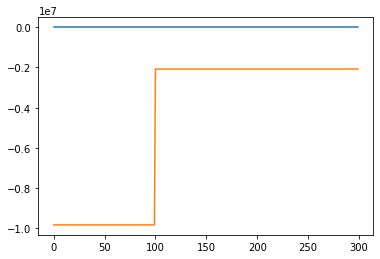

In [22]:
# One-step test

phi_t = []
mu_t = []

mx = 300

phi = np.zeros(mx)
phi[:100] = 1

cs = np.ones(mx)*3.06752518e-01
cs[:100] = 3.34696064e-01

mus = np.zeros(mx)
mus[:100] = mu_s(cs[:100],T)
mus[100:] = mu_l(cs[100:],T)

phi_t.append(phi)
plt.plot(phi)
mu_t.append(mus)

plt.plot(gp_s(mus,T,phi) - gp_l(mus,T,phi))

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99726508 0.00273492 

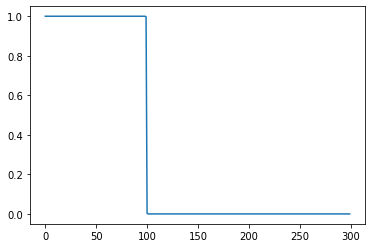

In [15]:
dphi_dt = (ep*sigma*lap(phi) - 2*W*sigma*phi*(1-phi)/ep - (gp_s(mus,T,phi) - gp_l(mus,T,phi))*6*phi*(1-phi))/(tau*ep)
phi += dphi_dt*dt
phi_t.append(phi)
    
dmu_dt = (0.5*D_l/a_liq(T)*(1-g(phi))*lap(mus) - 6*(c_s(mus,T) - c_l(mus,T))*phi*(1-phi)*dphi_dt)\
/(0.5*h(phi)/a_bcc(T) + 0.5*(1-h(phi))/a_liq(T))
    
mus += dmu_dt*dt
mu_t.append(mus)
    
apply_bc_phi(phi)
apply_bc_mu(mus)

print(phi)

plt.plot(phi)

In [16]:
# 1D simulation

phi_t = []
mu_t = []

mx = 300

phi = np.zeros(mx)
phi[:100] = 1

cs = np.ones(mx)*3.06752518e-01
cs[:100] = 3.34696064e-01

mus = np.zeros(mx)
mus[:100] = mu_s(cs[:100],T)
mus[100:] = mu_l(cs[100:],T)

timesteps = 10000

phi_t.append(np.copy(phi))
mu_t.append(np.copy(mus))

for t in range(timesteps):
    
    dphi_dt = (ep*sigma*lap(phi) - 2*W*sigma*phi*(1-phi)/ep - (gp_s(mus,T,phi) - gp_l(mus,T,phi))*6*phi*(1-phi))/(tau*ep)
    phi += dphi_dt*dt
    phi_t.append(np.copy(phi))
    
    dmu_dt = (0.5*D_l/a_liq(T)*(1-g(phi))*lap(mus) - 6*(c_s(mus,T) - c_l(mus,T))*phi*(1-phi)*dphi_dt)\
    /(0.5*h(phi)/a_bcc(T) + 0.5*(1-h(phi))/a_liq(T))
    
    mus += dmu_dt*dt
    mu_t.append(np.copy(mus))
    
    apply_bc_phi(phi)
    apply_bc_mu(mus)

In [17]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [18]:
%matplotlib inline
@interact(i=(0,9999,100))
def plotfn(i):
    
    fig,ax = plt.subplots(figsize=(10,8))

    ax.plot(phi_t[i],label='Phi',marker='o')
    ax.set_xlabel("x" + str(dx))
    ax.legend()

interactive(children=(IntSlider(value=4900, description='i', max=9999, step=100), Output()), _dom_classes=('wi…

In [19]:
%matplotlib inline
@interact(i=(0,9999,100))
def plotfn(i):
    
    fig,ax = plt.subplots(figsize=(10,8))

    ax.plot(c(mu_t[i],T,phi_t[i]),label='C')
    ax.legend()

interactive(children=(IntSlider(value=4900, description='i', max=9999, step=100), Output()), _dom_classes=('wi…

In [20]:
print(mu_s(3.34696064e-01,1805))
print(mu_l(3.06752518e-01,1805))

951991912.6114345
947359987.0627813
